tgn 실행할 때 GPU 연산률, GPU 사용률 다 체크/기록 할 것

# Dependency install

In [1]:
# Install PyTorch (CUDA 지원 버전)
!pip install torch==2.4.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

# Install PyG dependencies
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu124.html
!pip install torch-geometric


Looking in indexes: https://download.pytorch.org/whl/cu124
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu124.html


# Mount google drive

In [2]:
# CELL 1
#CIC-IDS-2017
from google.colab import drive

mount_path = "/content/data"
dir_path = mount_path + "/MyDrive/Project_Folder/TGN-NeuroSym/DATASETS/CIC-IDS-2017/GeneratedLabelledFlows/TrafficLabelling/"

drive.mount(mount_path)

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


# DATA Load + Random Forest code + Flow Bytes 전처리

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# 시각화 스타일 설정
sns.set(style="whitegrid")

# 파일 경로 설정 (사용하시는 파일명으로 꼭 수정해주세요!)
file_path = dir_path + 'Wednesday-workingHours.pcap_ISCX.csv'

print("✅ 라이브러리 임포트 및 설정 완료")

✅ 라이브러리 임포트 및 설정 완료


In [57]:
print("📂 데이터를 로드하는 중입니다... (1~2분 정도 소요될 수 있습니다)")
df = pd.read_csv(file_path)

# 1. 컬럼명 앞뒤 공백 제거 (매우 중요!)
df.columns = df.columns.str.strip()

# 2. 무한대(Infinity) 값 및 결측치(NaN) 제거
# Flow Bytes/s 등에서 0으로 나누는 경우 발생 가능한 무한대 값을 제거합니다.
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# Flow Bytes/s 미리 전처리, Flow Bytes/s가 오버플로우로 음수가 되는 오류 존재
# 따라서 Flow Bytes/s를 직접 계산하여 처리
rows_to_drop = df[df['Flow Duration'] == -1].index
df.drop(rows_to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)
"""
duration_seconds = df['Flow Duration'] / 1e6
total_bytes = df['Total Length of Fwd Packets'] + df['Total Length of Bwd Packets']
duration_seconds = duration_seconds.replace(0, 1e-6)
df['Flow Bytes/s'] = total_bytes / duration_seconds
df['Flow Bytes/s'] = df['Flow Bytes/s'].replace([np.inf, -np.inf], 0)
"""
print(f"✅ 데이터 로드 및 정제 완료!")
print(f"   - 최종 데이터 크기(Shape): {df.shape}")
print(f"   - 컬럼 목록 예시: {df.columns[:5].tolist()}")

📂 데이터를 로드하는 중입니다... (1~2분 정도 소요될 수 있습니다)
✅ 데이터 로드 및 정제 완료!
   - 최종 데이터 크기(Shape): (691385, 85)
   - 컬럼 목록 예시: ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port']


In [59]:
# 1. 속도를 위해 10%만 샘플링 (Feature Importance 뽑는 데는 충분합니다)
df_sample = df.sample(frac=0.1, random_state=42)

# 2. 제거할 컬럼 목록 (식별자 및 정답지)
# TGN의 'Edge Feature'로 넣기 부적절한 식별 정보들은 뺍니다.
drop_cols = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port',
             'Protocol', 'Timestamp', 'Label', 'Flow ID']

# 실제 데이터에 존재하는 컬럼만 골라서 제거 (에러 방지)
existing_drop_cols = [c for c in drop_cols if c in df_sample.columns]

# X: 순수 통계 정보
X = df_sample.drop(columns=existing_drop_cols)

# y: 공격 여부 (BENIGN은 0, 공격은 1)
y = np.where(df_sample['Label'] == 'BENIGN', 0, 1)

print(f"✅ 학습 데이터 준비 완료")
print(f"   - 학습에 사용할 샘플 수: {len(X)}")
print(f"   - 피처(X) 개수: {X.shape[1]}개")

✅ 학습 데이터 준비 완료
   - 학습에 사용할 샘플 수: 69138
   - 피처(X) 개수: 77개


In [60]:
print("🌲 랜덤 포레스트 학습 시작...")

# 모델 생성 (나무 100그루)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 학습 (Fit)
rf.fit(X, y)

print("✅ 학습 완료!")

🌲 랜덤 포레스트 학습 시작...
✅ 학습 완료!



🔥 [Top 20 핵심 피처 목록] 🔥
                        Feature  Importance
12        Bwd Packet Length Std    0.101320
39           Packet Length Mean    0.074937
51          Average Packet Size    0.051549
11       Bwd Packet Length Mean    0.050384
9         Bwd Packet Length Max    0.048414
36                Bwd Packets/s    0.047393
64            Subflow Bwd Bytes    0.046940
38            Max Packet Length    0.043226
65       Init_Win_bytes_forward    0.041958
41       Packet Length Variance    0.036219
53         Avg Bwd Segment Size    0.032880
40            Packet Length Std    0.027082
4   Total Length of Bwd Packets    0.021931
52         Avg Fwd Segment Size    0.020936
13                 Flow Bytes/s    0.020685
2        Total Backward Packets    0.020633
34            Bwd Header Length    0.019862
7        Fwd Packet Length Mean    0.016999
66      Init_Win_bytes_backward    0.015997
20                 Fwd IAT Mean    0.015466


/tmp/ipython-input-3426864958.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')


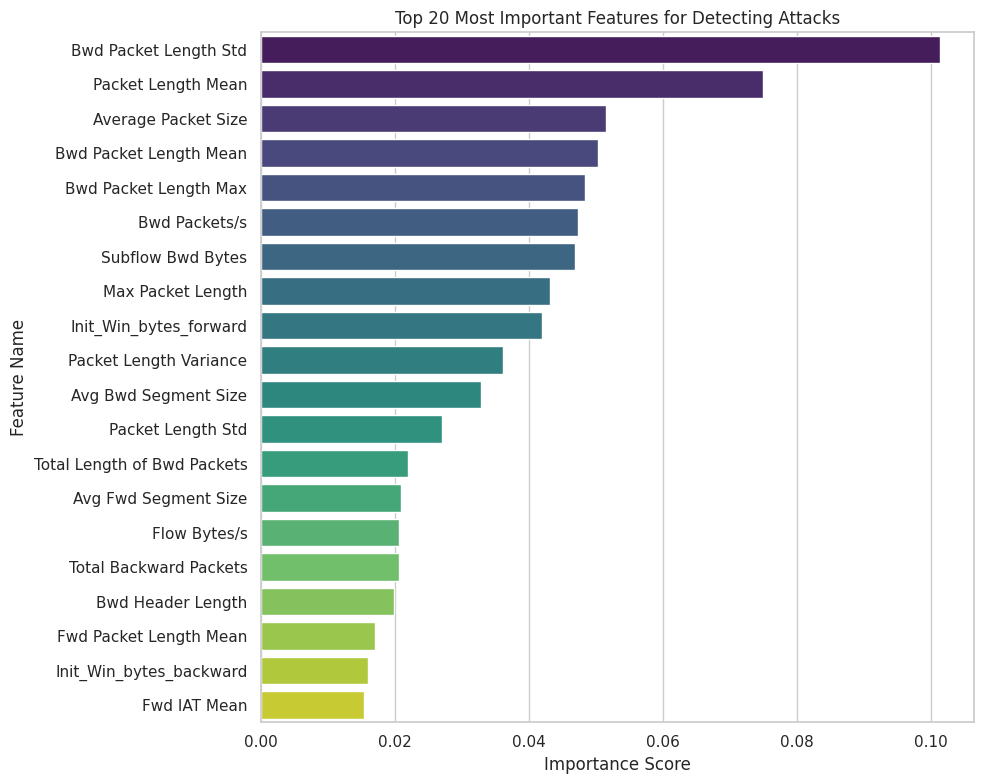

In [61]:
# 중요도 추출
importances = rf.feature_importances_
feature_names = X.columns

# 데이터프레임으로 변환 및 정렬
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# ---------------- 결과 출력 ----------------
print("\n🔥 [Top 20 핵심 피처 목록] 🔥")
print(feature_imp_df.head(20))

# ---------------- 시각화 ----------------
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')
plt.title('Top 20 Most Important Features for Detecting Attacks')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

# Based on RF, make the learnable CIC-IDS-2017 data

In [63]:
# key feature 8개 + msg featrue 20개 만 남기고 나머지 모두 제거
choosed_feature = list(feature_imp_df.head(20)['Feature'])
key_cols = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port',
             'Protocol', 'Timestamp', 'Label', 'Flow ID']
drop_cols = list(set(df.columns) - set(choosed_feature + key_cols))
df = df.drop(columns=drop_cols)

# Flow ID도 필요가 없음
df = df.drop(columns="Flow ID")
preprocessed_df = None

KeyError: "['Flow ID'] not found in axis"

## 1. src, dst, time 전처리

In [67]:
# (src, dst, time, msg) 형태로 변환
# (src, dst, time ,msg) = (Source IP, Destination IP, Timestampe, rest of the dataframe)

#src,dst 전처리 src,dst IP -> node num
# ==========================================
# lobal Node Map 생성 (Source + Destination 통합)
# ==========================================
# 보내는 사람(Src)과 받는 사람(Dst)을 합쳐서 전체 네트워크의 '등장인물(Node)' 목록을 만듭니다.
src_ips = df['Source IP'].unique()
dst_ips = df['Destination IP'].unique()

# 합치고, 중복 제거하고, 정렬(Sorting) -> 정렬해야 매번 실행할 때마다 ID가 같게 유지됩니다.
all_ips = np.unique(np.concatenate((src_ips, dst_ips)))

print(f"총 고유 IP(노드) 개수: {len(all_ips)}")

# IP -> ID (Integer) 딕셔너리 생성
ip_to_idx = {ip: i for i, ip in enumerate(all_ips)}

# ID -> IP (나중에 결과 해석할 때 사용)
idx_to_ip = {i: ip for ip, i in ip_to_idx.items()}

총 고유 IP(노드) 개수: 9015


In [68]:
# ==========================================
# DataFrame에 매핑 적용
# ==========================================
# map 함수를 쓰면 매우 빠릅니다.
df['src_idx'] = df['Source IP'].map(ip_to_idx)
df['dst_idx'] = df['Destination IP'].map(ip_to_idx)

# 결과 확인
print("\n[매핑 완료된 데이터프레임]")
print(df[['Source IP', 'src_idx', 'Destination IP', 'dst_idx']].head())


[매핑 완료된 데이터프레임]
       Source IP  src_idx Destination IP  dst_idx
0  192.168.10.14     2602  209.48.71.168     3346
1  192.168.10.17     2605   192.168.10.3     2609
2  192.168.10.17     2605   192.168.10.3     2609
3  192.168.10.17     2605   192.168.10.3     2609
4  192.168.10.17     2605   192.168.10.3     2609


In [69]:
# time 전처리
# -------------------------------------------------------------------------
# [Step 1] 문자열 -> Datetime 객체로 변환
# -------------------------------------------------------------------------
# format='%d/%m/%Y %H:%M' 설명:
# 주의: 만약 데이터에 '오전/오후'가 있거나 '초'가 포함된 행이 섞여 있다면 format을 지우고 실행하세요.
df['dt'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M')

# -------------------------------------------------------------------------
# [Step 2] Datetime -> Unix Timestamp (초 단위 정수) 변환
# -------------------------------------------------------------------------
# 판다스 내부적으로 나노초(ns) 단위 정수로 저장되므로 10의 9승으로 나누어 줍니다.
df['unix_ts'] = df['dt'].astype('int64') // 10**9

# -------------------------------------------------------------------------
# [Step 3] (TGN 추천) 첫 데이터를 0초로 맞춘 '상대 시간' 생성
# -------------------------------------------------------------------------
# 모델이 학습할 때 숫자가 작을수록 더 잘 학습합니다.
start_time = df['unix_ts'].min()
df['ts_norm'] = df['unix_ts'] - start_time

print(df[['Timestamp', 'dt', 'unix_ts', 'ts_norm']].head())

       Timestamp                  dt     unix_ts  ts_norm
0  5/7/2017 8:42 2017-07-05 08:42:00  1499244120    27720
1  5/7/2017 8:42 2017-07-05 08:42:00  1499244120    27720
2  5/7/2017 8:42 2017-07-05 08:42:00  1499244120    27720
3  5/7/2017 8:42 2017-07-05 08:42:00  1499244120    27720
4  5/7/2017 8:42 2017-07-05 08:42:00  1499244120    27720


## 2. Msg 전처리, 여기선 df 원본값을 건듬

In [76]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

selected_features = ['Source Port', 'Destination Port',
       'Protocol'] + choosed_feature
print("Msg로 사용될 columns 수 : ",len(selected_features)) # 23 = 20 feature + 1 protocol + 2 src, dst port

# 1. 로그 변환이 필요한 컬럼 (값이 매우 크거나 치우친 분포)
log_cols = [
    'Flow Bytes/s', 'Bwd Packets/s',
    'Total Length of Bwd Packets', 'Subflow Bwd Bytes',
    'Packet Length Variance',
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward'
]

# Init_Win_bytes는 TCP연결시 상대방에게 보내는 내 수신버퍼의 여유 크기를 의미
# forward는 src가 dst에게 보낸 내용, backward는 반대.
# -1이면 UDP연결을 의미하고 이는 log(1+x)에 넣을 수 없으므로 0으로 처리
df['Init_Win_bytes_forward'] = df['Init_Win_bytes_forward'].replace(-1, 0)
df['Init_Win_bytes_backward'] = df['Init_Win_bytes_backward'].replace(-1, 0)

# Flow Bytes/s가 버퍼 오버플로우로 인해 음수 데이터가 일부 있음

# np.log1p는 log(x+1)을 계산해줍니다 (0인 경우 -inf가 나오는 것을 방지)
# 에러 방지를 위해 미리 float 변환 후 적용
for col in log_cols:
    if col in df.columns:
        df[col] = np.log1p(df[col].astype(float))

print("1. 로그 변환 완료")

# 2. 포트 번호 정규화 (0~65535 -> 0~1)
port_cols = ['Source Port', 'Destination Port']
for col in port_cols:
    if col in df.columns:
        df[col] = df[col].astype(float) / 65535.0

print("2. 포트 정규화 완료")


Msg로 사용될 columns 수 :  23
1. 로그 변환 완료
2. 포트 정규화 완료


In [77]:
fb = "Flow Bytes/s"
df[fb][df[fb].isna()]

,Flow Bytes/s


# Label 전처리, df 실제 값 바꿈

In [78]:
df["Label"] = (df["Label"] != "BENIGN").astype(int)

# Normalize data + convert df to tensor


In [79]:
# 3. 나머지 모든 컬럼 표준화 (Standard Scaling)
# 위에서 처리한 로그 변환된 값들도 스케일이 제각각이므로,
# 마지막에 전체적으로 한번 싹 표준화 해주는 게 베스트입니다.

# StandardScaler 적용 (평균 0, 분산 1로 통일)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

print("3. 전체 표준화 완료 (이제 Tensor로 바꿔도 안전합니다)")

# 결과 확인
print(df[selected_features].describe())

3. 전체 표준화 완료 (이제 Tensor로 바꿔도 안전합니다)
        Source Port  Destination Port      Protocol  Bwd Packet Length Std  \
count  6.913850e+05      6.913850e+05  6.913850e+05           6.913850e+05   
mean   7.432393e-17      4.012177e-17  1.933738e-16          -3.088061e-16   
std    1.000001e+00      1.000001e+00  1.000001e+00           1.000001e+00   
min   -2.179793e+00     -3.614613e-01 -1.840497e+00          -6.006053e-01   
25%   -3.251206e-01     -3.580902e-01 -6.435094e-01          -6.006053e-01   
50%    3.705609e-01     -3.563729e-01 -6.435094e-01          -6.006053e-01   
75%    7.323746e-01     -3.332843e-01  1.550968e+00           2.507620e-01   
max    1.174495e+00      3.803843e+00  1.550968e+00           5.511772e+00   

       Packet Length Mean  Average Packet Size  Bwd Packet Length Mean  \
count        6.913850e+05         6.913850e+05            6.913850e+05   
mean        -3.870764e-16         1.098416e-16            1.055663e-16   
std          1.000001e+00         1.000

In [80]:
import torch

preprocessed_df = pd.DataFrame(df[['src_idx','dst_idx','ts_norm'] + selected_features + ['Label']])
#print(preprocessed_df.head(3))

tensor = torch.tensor(preprocessed_df.values, dtype=torch.float32)
tensor.shape #  src 1, dst 1, time 1, msg 23(20+port 2+protocol), label 1

torch.Size([691385, 27])

# To do!! 텐서로 변환하기전에 전체 결측치 값 유무 확인해야함


# Tensor to Temporaldata before TGN

In [81]:
import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear
import os.path as osp

from torch_geometric.data import TemporalData
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import IdentityMessage, LastAggregator, LastNeighborLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------------------------------------
# 1. 슬라이싱으로 쪼개기 (인덱스는 본인 데이터 순서에 맞게 조정 필요)
# -----------------------------------------------------------

# [:, 0] -> 모든 행의 0번째 컬럼 (src)
# .long() -> ID는 반드시 정수여야 임베딩 룩업이 가능함
src = tensor[:, 0].long()

# [:, 1] -> 모든 행의 1번째 컬럼 (dst)
dst = tensor[:, 1].long()

# [:, 2] -> 모든 행의 2번째 컬럼 (time)
# 시간은 int(long)여도 되고 float여도 되는데, 보통 long을 많이 씁니다.
t = tensor[:, 2].long()

# [:, 3:26] -> 3번부터 25번까지 (26 바로 앞까지) -> 총 23개
# 메시지는 신경망 연산에 쓰이므로 float32여야 함
msg = tensor[:, 3:26].float()

# [:, 26] -> 마지막 26번째 컬럼 (label)
# 분류 문제(CrossEntropyLoss)의 정답지는 보통 long 형이어야 함
y = tensor[:, 26].long()

# -----------------------------------------------------------
# 2. TemporalData 생성
# -----------------------------------------------------------
data = TemporalData(
    src=src,
    dst=dst,
    t=t,
    msg=msg,
    y=y
).to(device)

# -----------------------------------------------------------
# 3. 잘 들어갔는지 검증
# -----------------------------------------------------------
print("데이터 변환 완료!")
print(f"전체 데이터 개수: {data.num_events}")
print(f"Msg(Feature) 개수: {data.msg.size(1)} (23개가 나와야 함)")
print(f"데이터 샘플:\n{data}")

데이터 변환 완료!
전체 데이터 개수: 691385
Msg(Feature) 개수: 23 (23개가 나와야 함)
데이터 샘플:
TemporalData(src=[691385], dst=[691385], t=[691385], msg=[691385, 23], y=[691385])


In [82]:
print(torch.isnan(tensor).any())
print(torch.isnan(tensor).sum())
idx = torch.isnan(tensor).nonzero(as_tuple=True)
print(idx)
print(torch.isinf(tensor).any())
for i in range(0, 27):
  print(i,' : ',tensor[:,i].isnan().any())

tensor(False)
tensor(0)
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
tensor(False)
0  :  tensor(False)
1  :  tensor(False)
2  :  tensor(False)
3  :  tensor(False)
4  :  tensor(False)
5  :  tensor(False)
6  :  tensor(False)
7  :  tensor(False)
8  :  tensor(False)
9  :  tensor(False)
10  :  tensor(False)
11  :  tensor(False)
12  :  tensor(False)
13  :  tensor(False)
14  :  tensor(False)
15  :  tensor(False)
16  :  tensor(False)
17  :  tensor(False)
18  :  tensor(False)
19  :  tensor(False)
20  :  tensor(False)
21  :  tensor(False)
22  :  tensor(False)
23  :  tensor(False)
24  :  tensor(False)
25  :  tensor(False)
26  :  tensor(False)


# TGN public code start

In [83]:
train_data, val_data, test_data = data.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15
)
train_loader = TemporalDataLoader(train_data, batch_size=200, neg_sampling_ratio=1.0)
val_loader = TemporalDataLoader(val_data, batch_size=200, neg_sampling_ratio=1.0)
test_loader = TemporalDataLoader(test_data, batch_size=200, neg_sampling_ratio=1.0)

neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)

# Global index → Local index 매핑용 텐서
assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)

In [84]:
class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(
            in_channels, out_channels // 2, heads=2,
            dropout=0.1, edge_dim=edge_dim
        )

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = torch.relu(h)
        return self.lin_final(h)


In [85]:
memory_dim = 128
time_dim = embedding_dim = 100

memory = TGNMemory(
    data.num_nodes,
    data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)

link_pred = LinkPredictor(in_channels=embedding_dim).to(device)

optimizer = torch.optim.Adam(
    list(memory.parameters()) +
    list(gnn.parameters()) +
    list(link_pred.parameters()),
    lr=0.0001
)

criterion = torch.nn.BCEWithLogitsLoss()


/usr/local/lib/python3.12/dist-packages/torch/_compile.py:31: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


In [86]:
def train():
    memory.train()
    gnn.train()
    link_pred.train()

    memory.reset_state()
    neighbor_loader.reset_state()

    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id], data.msg[e_id])

        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))

        memory.update_state(batch.src, batch.dst, batch.t.long(), batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()

        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events


In [87]:
@torch.no_grad()
def test(loader):
    memory.eval()
    gnn.eval()
    link_pred.eval()

    torch.manual_seed(12345)

    aps, aucs = [], []
    for batch in loader:
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id], data.msg[e_id])

        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        y_true = torch.cat([
            torch.ones(pos_out.size(0)),
            torch.zeros(neg_out.size(0))
        ], dim=0)

        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean())


In [88]:
for epoch in range(1, 5):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

    val_ap, val_auc = test(val_loader)
    test_ap, test_auc = test(test_loader)

    print(f'Val AP:  {val_ap:.4f}, Val AUC:  {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')


Epoch: 01, Loss: 0.3021
Val AP:  0.9729, Val AUC:  0.9707
Test AP: 0.9711, Test AUC: 0.9737
Epoch: 02, Loss: 0.2601
Val AP:  0.9725, Val AUC:  0.9707
Test AP: 0.9709, Test AUC: 0.9741
Epoch: 03, Loss: 0.2501
Val AP:  0.9743, Val AUC:  0.9699
Test AP: 0.9726, Test AUC: 0.9678
Epoch: 04, Loss: 0.2467
Val AP:  0.9786, Val AUC:  0.9746
Test AP: 0.9803, Test AUC: 0.9770
